In [1]:
from typing import Literal

import networkx as nx
import nest_asyncio
import pandas as pd
import pytorch_lightning as pl
from sklearn.preprocessing import LabelEncoder
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import from_networkx

from modules import dataset, graph, model

In [2]:
# Allows for asyncio to be run in notebooks
nest_asyncio.apply()

In [3]:
# Load the dataset

# How many nodes to include in the graph
max_nodes: int = 20

# Label encoder
label_encoder: LabelEncoder = LabelEncoder()

# Prepare the training set
train_set: pd.DataFrame = dataset.prepare_dataset('train', max_pages = max_nodes)
train_x: pd.DataFrame = train_set.drop(columns=['label'])
label_encoder.fit(train_set['label'])
train_y: torch.Tensor = torch.tensor(label_encoder.transform(train_set['label']))

# Prepare the validation set
valid_set: pd.DataFrame = dataset.prepare_dataset('valid')
valid_x: pd.DataFrame = valid_set.drop(columns=['label'])
valid_y: torch.Tensor = torch.tensor(label_encoder.transform(valid_set['label']))

[('enwiki', {'x': (4338.0,)}), ('frwiki', {'x': (10690.0,)}), ('dewiki', {'x': (10718.0,)}), ('eswiki', {'x': (1469.0,)}), ('ruwiki', {'x': (7709.0,)}), ('nlwiki', {'x': (2236.0,)}), ('jawiki', {'x': (5549.0,)}), ('svwiki', {'x': (1114.0,)}), ('commonswiki', {'x': (146.0,)}), ('trwiki', {'x': (701.0,)}), ('eowiki', {'x': (1916.0,)}), ('simplewiki', {'x': (1251.0,)}), ('ptwiki', {'x': (0.0,)}), ('cawiki', {'x': (0.0,)}), ('arwiki', {'x': (0.0,)}), ('plwiki', {'x': (0.0,)}), ('ukwiki', {'x': (0.0,)}), ('zhwiki', {'x': (0.0,)}), ('fawiki', {'x': (0.0,)}), ('kowiki', {'x': (0.0,)}), ('cswiki', {'x': (0.0,)}), ('nowiki', {'x': (0.0,)}), ('hewiki', {'x': (0.0,)}), ('huwiki', {'x': (0.0,)}), ('euwiki', {'x': (0.0,)}), ('itwiki', {'x': (0.0,)}), ('idwiki', {'x': (0.0,)}), ('fiwiki', {'x': (0.0,)}), ('dawiki', {'x': (0.0,)}), ('arzwiki', {'x': (0.0,)})]
[('enwiki', {'x': (49535.0,)}), ('frwiki', {'x': (25835.0,)}), ('dewiki', {'x': (14256.0,)}), ('eswiki', {'x': (5575.0,)}), ('itwiki', {'x': (2

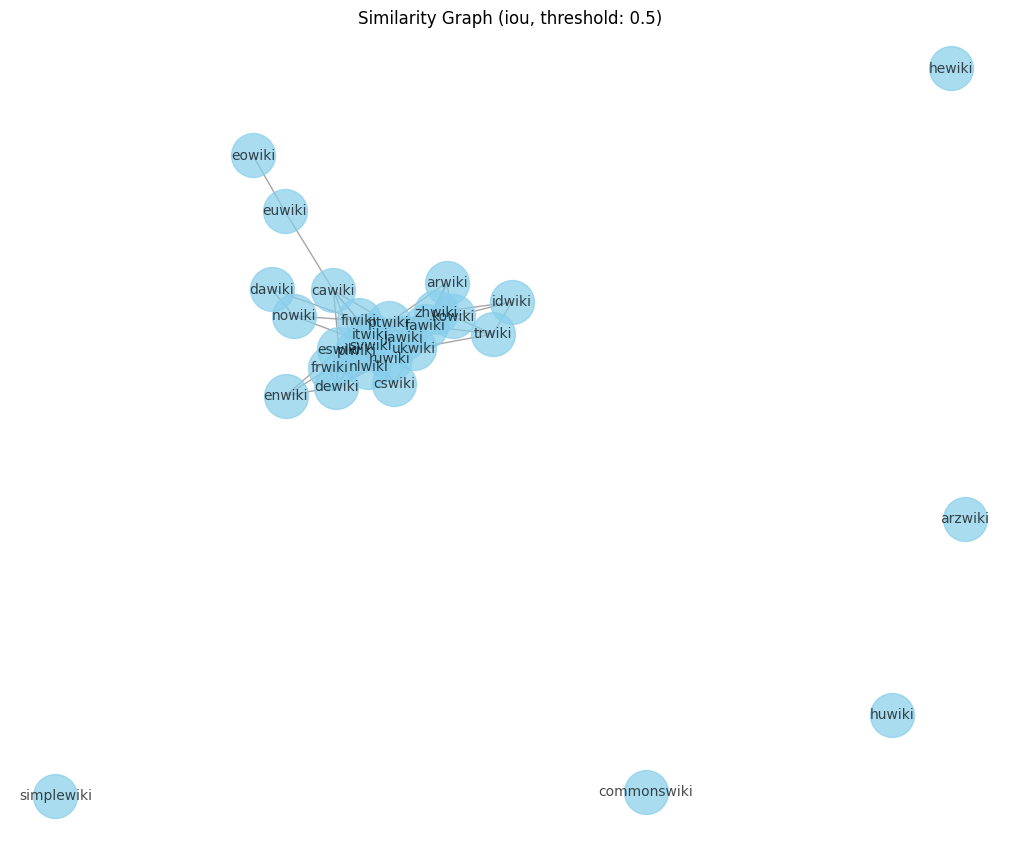

In [4]:
# Create the graphs

# Parameters
mode: Literal['iou', 'correlation', 'filtered correlation'] = 'iou'
treshold: float = 0.5

training_graphs: list[nx.Graph] = graph.get_similarity_graphs(train_x, similarity_threshold=treshold, mode=mode, save_fig=True)
validation_graphs: list[nx.Graph] = graph.get_similarity_graphs(valid_x, similarity_threshold=treshold, mode=mode)

In [5]:
# Create the dataloaders

batch_size: int = 16

train_data: list[Data] = []
for graph, label in zip(training_graphs, train_y):
    data: Data = from_networkx(graph)
    data.y = label
    train_data.append(data)
train_loader: DataLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

valid_data: list[Data] = []
for graph, label in zip(validation_graphs, valid_y):
    data: Data = from_networkx(graph)
    data.y = label
    valid_data.append(data)
valid_loader: DataLoader = DataLoader(valid_data, batch_size=batch_size)

In [6]:
# Create the model and the trainer

gcn: model.GCN = model.GCN(input_dim = 1,
                           hidden_dim = 32,
                           output_dim = 3
                           )

trainer: pl.Trainer = pl.Trainer(max_epochs = 3,
                                 log_every_n_steps = 1
                                 )

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
# Train the model
trainer.fit(gcn, train_loader, valid_loader)


  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | conv1 | GCNConv          | 64     | train
1 | conv2 | GCNConv          | 1.1 K  | train
2 | fc    | Linear           | 99     | train
3 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Valerio\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


ValueError: Expected input batch_size (480) to match target batch_size (16).